
=== Running experiments on Function1 ===
Running combination: FPS + Truncation
Running combination: FPS + Tournament
Running combination: RBS + Truncation
Running combination: RBS + Tournament
Running combination: Tournament + Truncation
Running combination: Tournament + Tournament


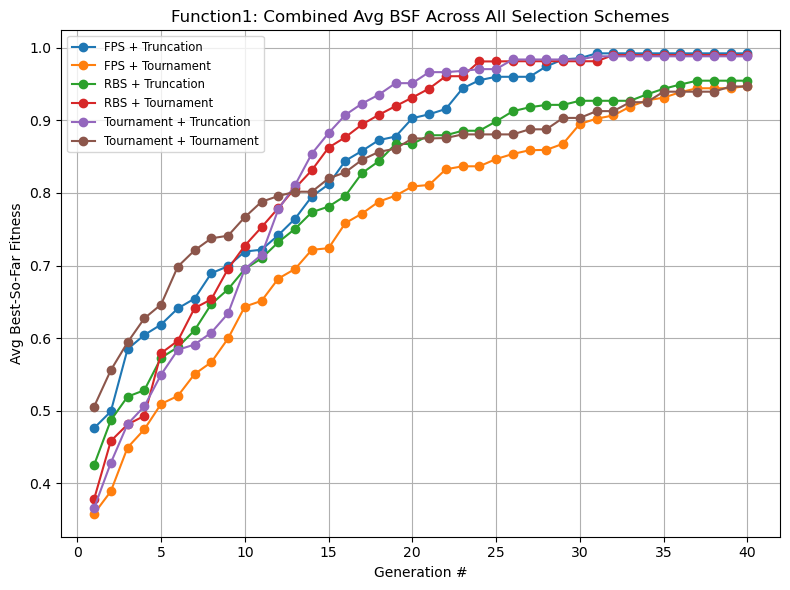

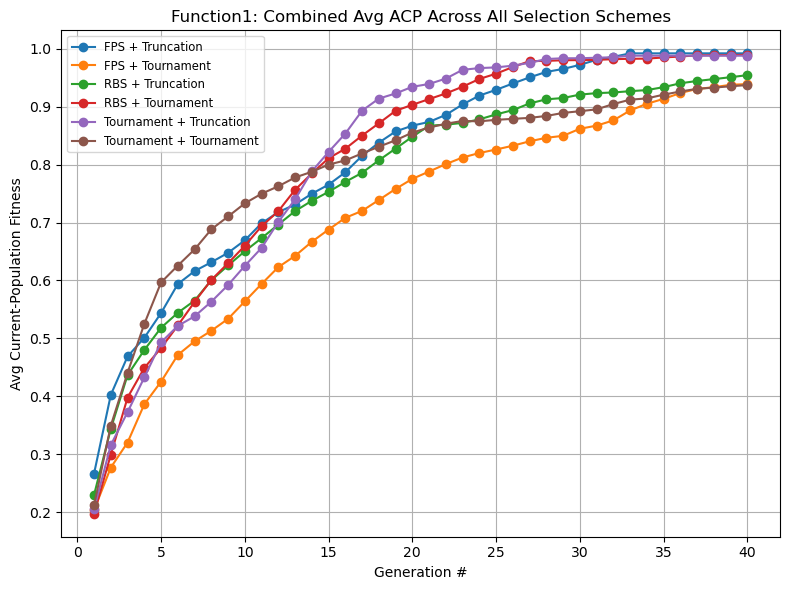


=== Running experiments on Function2 ===
Running combination: FPS + Truncation
Running combination: FPS + Tournament
Running combination: RBS + Truncation
Running combination: RBS + Tournament
Running combination: Tournament + Truncation
Running combination: Tournament + Tournament


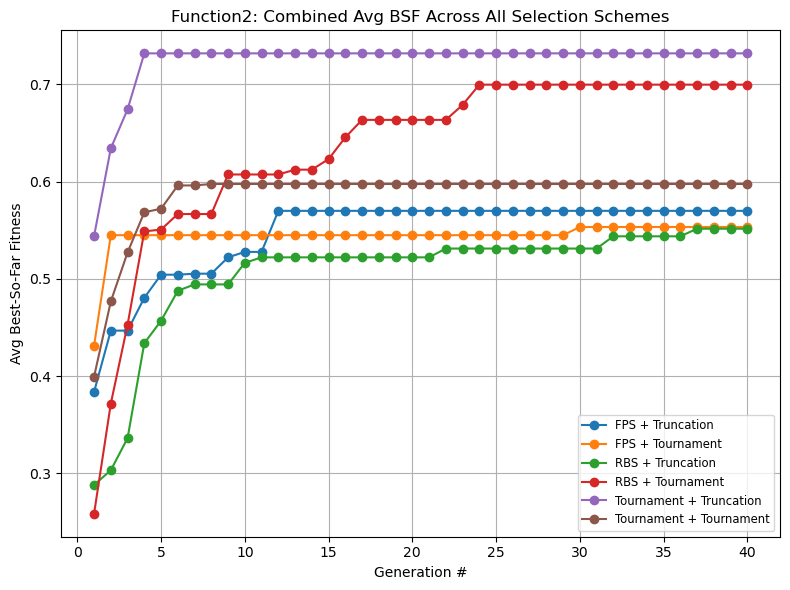

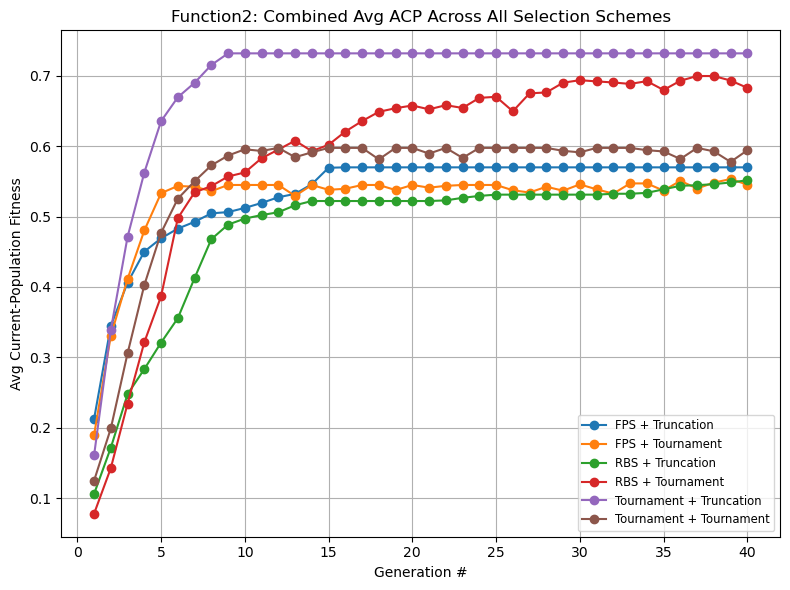

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============================================
# Objective Functions
# ============================================

def func1(x, y):
    """
    Function 1: f(x, y) = x^2 + y^2
    Domain: -5 < x, y < 5
    """
    return x**2 + y**2

def func2(x, y):
    """
    Function 2: f(x, y) = 100 * (x^2 – y)^2 + (1 – x)^2
    Domain: -2 < x < 2, -1 < y < 3
    """
    return 100.0 * (x**2 - y)**2 + (1.0 - x)**2

# ============================================
# Fitness Transformation (for minimization → maximization)
# ============================================

def fitness_from_objective(f_vals):
    """
    Convert objective values (to be minimized) into fitness values (to be maximized).
    We use fitness = 1 / (1 + f), so fitness is in (0, 1] for f ≥ 0.
    """
    return 1.0 / (1.0 + f_vals)

# ============================================
# Population Initialization
# ============================================

def initialize_population(pop_size, domain):
    """
    Initialize 'pop_size' individuals uniformly at random within the given domain.
    Args:
        pop_size: int, number of individuals.
        domain: tuple of bounds ((x_min, x_max), (y_min, y_max)).
    Returns:
        population: NumPy array of shape (pop_size, 2), each row is [x, y].
    """
    (x_min, x_max), (y_min, y_max) = domain
    xs = np.random.uniform(x_min, x_max, size=pop_size)
    ys = np.random.uniform(y_min, y_max, size=pop_size)
    return np.column_stack((xs, ys))

# ============================================
# Selection Operators
# ============================================

def fps_selection(population, fitnesses, num_parents):
    """
    Fitness-Proportionate Selection (Roulette Wheel).
    Returns 'num_parents' individuals chosen (with replacement) from 'population'.
    """
    total_fit = np.sum(fitnesses)
    if total_fit <= 0:
        # In degenerate case (all fitnesses = 0), return random individuals
        indices = np.random.choice(len(population), size=num_parents, replace=True)
        return population[indices]
    probs = fitnesses / total_fit
    indices = np.random.choice(len(population), size=num_parents, replace=True, p=probs)
    return population[indices]

def rbs_selection(population, fitnesses, num_parents):
    """
    Rank-Based Selection.
    Sort population by fitness (descending), assign linear rank-based probabilities.
    p_i = (2 * (N + 1 - rank_i)) / (N * (N + 1))
    Then sample 'num_parents' with replacement according to p_i.
    """
    N = len(population)
    # Sort indices by descending fitness
    sorted_idx = np.argsort(-fitnesses)
    # ranks: best individual has rank 1, worst has rank N
    ranks = np.empty(N, dtype=int)
    ranks[sorted_idx] = np.arange(1, N + 1)
    # Compute selection probabilities based on rank
    probs = (2.0 * (N + 1 - ranks)) / (N * (N + 1))
    # Normalize to ensure sum to 1 (floating point safeguards)
    probs = probs / np.sum(probs)
    # Sample
    indices = np.random.choice(N, size=num_parents, replace=True, p=probs)
    return population[indices]

def tournament_selection(population, fitnesses, num_parents, tournament_size=2):
    """
    Binary Tournament Selection (tournament_size=2).
    For each parent to select: pick 'tournament_size' individuals uniformly at random, return the best.
    Returns 'num_parents' selected individuals (with replacement in tournaments).
    """
    selected = []
    N = len(population)
    for _ in range(num_parents):
        # Randomly pick 'tournament_size' distinct candidates
        candidates = np.random.choice(N, size=tournament_size, replace=False)
        # Choose the one with highest fitness
        best_idx = candidates[np.argmax(fitnesses[candidates])]
        selected.append(population[best_idx])
    return np.array(selected)

# ============================================
# Crossover and Mutation (Real-Coded)
# ============================================

def uniform_crossover(parent1, parent2):
    """
    Uniform crossover for two parent vectors (size=2).
    For each gene (x or y), flip a fair coin to decide which parent's gene to take.
    """
    child = np.empty_like(parent1)
    for i in range(2):
        if random.random() < 0.5:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

def mutate(individual, domain, mutation_prob=0.1, mutation_step=0.25):
    """
    Mutate a real-valued individual [x, y].
    For each gene, with probability 'mutation_prob', add or subtract 'mutation_step'.
    After mutation, clamp gene to within 'domain'.
    """
    (x_min, x_max), (y_min, y_max) = domain
    new = individual.copy()
    for i in range(2):
        if random.random() < mutation_prob:
            # choose + or -
            delta = mutation_step if random.random() < 0.5 else -mutation_step
            new[i] += delta
    # Clamp to domain
    new[0] = np.clip(new[0], x_min, x_max)
    new[1] = np.clip(new[1], y_min, y_max)
    return new

# ============================================
# Survival Selection (Truncation & Binary Tournament)
# ============================================

def truncation_selection(combined_pop, combined_fitnesses, survivors_count):
    """
    Truncation: pick the top 'survivors_count' individuals by fitness from 'combined_pop'.
    """
    sorted_idx = np.argsort(-combined_fitnesses)  # descending fitness
    selected_idx = sorted_idx[:survivors_count]
    return combined_pop[selected_idx]

def survival_tournament_selection(combined_pop, combined_fitnesses, survivors_count):
    """
    Binary Tournament Survival Selection without replacement.
    Randomly pair up the combined population into pairs; from each pair,
    the one with higher fitness survives. This yields 'survivors_count' survivors
    if combined_pop has size = 2 * survivors_count.
    """
    N = len(combined_pop)
    assert N == 2 * survivors_count, "Combined population size must be twice survivors_count."
    indices = np.arange(N)
    np.random.shuffle(indices)
    survivors = []
    for i in range(0, N, 2):
        idx1, idx2 = indices[i], indices[i + 1]
        if combined_fitnesses[idx1] >= combined_fitnesses[idx2]:
            survivors.append(combined_pop[idx1])
        else:
            survivors.append(combined_pop[idx2])
    return np.array(survivors)

# ============================================
# One GA Run (Single Combination of Selection Schemes)
# ============================================

def run_one_ga_run(
    objective_fn,
    domain,
    pop_size,
    num_generations,
    parent_selection_method,
    survival_selection_method,
    mutation_prob=0.1,
    mutation_step=0.25
):
    """
    Run a single GA run for 'num_generations' on 'objective_fn' with given selection methods.
    Args:
        objective_fn: function f(x, y) to minimize.
        domain: ((x_min, x_max), (y_min, y_max))
        pop_size: number of individuals (N = 10)
        num_generations: number of generations (G = 40)
        parent_selection_method: one of 'FPS', 'RBS', 'Tournament'
        survival_selection_method: one of 'Truncation', 'Tournament'
        mutation_prob: probability of mutating each gene
        mutation_step: magnitude of mutation step (±)
    Returns:
        bsf_history: list of length num_generations, best-so-far fitness at each gen
        avg_history: list of length num_generations, average fitness of current population each gen
    """
    # Initialize population
    pop = initialize_population(pop_size, domain)  # shape (pop_size, 2)
    # Evaluate initial population
    obj_vals = np.array([objective_fn(ind[0], ind[1]) for ind in pop])
    fitnesses = fitness_from_objective(obj_vals)
    # Initialize best-so-far
    best_so_far = np.max(fitnesses)
    bsf_history = []
    avg_history = []

    for gen in range(num_generations):
        # --- Parent Selection ---
        if parent_selection_method == 'FPS':
            parents = fps_selection(pop, fitnesses, pop_size)
        elif parent_selection_method == 'RBS':
            parents = rbs_selection(pop, fitnesses, pop_size)
        elif parent_selection_method == 'Tournament':
            parents = tournament_selection(pop, fitnesses, pop_size, tournament_size=2)
        else:
            raise ValueError(f"Unknown parent selection method '{parent_selection_method}'")

        # --- Crossover & Mutation to produce 'pop_size' offspring ---
        offspring = np.zeros_like(parents)
        for i in range(pop_size):
            # Select two parents (with replacement) for mating
            p1_idx, p2_idx = np.random.choice(pop_size, size=2, replace=True)
            p1, p2 = parents[p1_idx], parents[p2_idx]
            child = uniform_crossover(p1, p2)
            child = mutate(child, domain, mutation_prob, mutation_step)
            offspring[i] = child

        # --- Evaluate Offspring ---
        obj_off = np.array([objective_fn(ind[0], ind[1]) for ind in offspring])
        fit_off = fitness_from_objective(obj_off)

        # --- Combine Parents (current pop) and Offspring ---
        combined_pop = np.vstack((pop, offspring))
        combined_fit = np.concatenate((fitnesses, fit_off))

        # --- Survival Selection ---
        if survival_selection_method == 'Truncation':
            next_pop = truncation_selection(combined_pop, combined_fit, pop_size)
        elif survival_selection_method == 'Tournament':
            # Combined size must be twice pop_size
            next_pop = survival_tournament_selection(combined_pop, combined_fit, pop_size)
        else:
            raise ValueError(f"Unknown survival selection method '{survival_selection_method}'")

        # --- Prepare Next Generation ---
        pop = next_pop
        obj_vals = np.array([objective_fn(ind[0], ind[1]) for ind in pop])
        fitnesses = fitness_from_objective(obj_vals)

        # --- Record Metrics ---
        current_best = np.max(fitnesses)
        best_so_far = max(best_so_far, current_best)
        bsf_history.append(best_so_far)
        avg_history.append(np.mean(fitnesses))

    return bsf_history, avg_history

# ============================================
# Experiment Runner (10 Runs + Averaging)
# ============================================

def run_experiment(
    objective_fn,
    domain,
    pop_size=10,
    num_generations=40,
    parent_selection_method='FPS',
    survival_selection_method='Truncation',
    num_runs=10,
    mutation_prob=0.1,
    mutation_step=0.25
):
    """
    Run 'num_runs' independent runs of the GA and compute average BSF and average ACP per generation.
    Returns:
        avg_bsf: length num_generations, average best-so-far fitness across runs
        avg_acp: length num_generations, average of current-population fitness across runs
    """
    all_bsf = np.zeros((num_runs, num_generations))
    all_acp = np.zeros((num_runs, num_generations))

    for run_idx in range(num_runs):
        bsf_hist, avg_hist = run_one_ga_run(
            objective_fn=objective_fn,
            domain=domain,
            pop_size=pop_size,
            num_generations=num_generations,
            parent_selection_method=parent_selection_method,
            survival_selection_method=survival_selection_method,
            mutation_prob=mutation_prob,
            mutation_step=mutation_step
        )
        all_bsf[run_idx, :] = bsf_hist
        all_acp[run_idx, :] = avg_hist

    avg_bsf = np.mean(all_bsf, axis=0)
    avg_acp = np.mean(all_acp, axis=0)
    return avg_bsf, avg_acp

# ============================================
# Plotting Utilities
# ============================================

def plot_metric(metric_dict, ylabel, title):
    """
    Plot multiple metrics (from different combinations) over generations in a single figure.
    Args:
        metric_dict: dict mapping label -> list/array of length num_generations
        ylabel: string for the y-axis label
        title: string for the plot title
    """
    gens = np.arange(1, len(next(iter(metric_dict.values()))) + 1)
    plt.figure(figsize=(8, 6))
    for label, values in metric_dict.items():
        plt.plot(gens, values, marker='o', label=label)
    plt.xlabel('Generation #')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================
# Main: Running All Combinations + Combined Plots
# ============================================

if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Problem definitions
    problems = {
        'Function1': {
            'fn': func1,
            'domain': ((-5.0, 5.0), (-5.0, 5.0))
        },
        'Function2': {
            'fn': func2,
            'domain': ((-2.0, 2.0), (-1.0, 3.0))
        }
    }

    parent_methods = ['FPS', 'RBS', 'Tournament']
    survival_methods = ['Truncation', 'Tournament']

    pop_size = 10
    num_generations = 40
    num_runs = 10
    mutation_prob = 0.1
    mutation_step = 0.25

    # Loop over each problem separately
    for prob_name, prob_data in problems.items():
        objective_fn = prob_data['fn']
        domain = prob_data['domain']

        print(f"\n=== Running experiments on {prob_name} ===")

        # Dictionaries to store average BSF and ACP for each combination
        combined_bsf = {}
        combined_acp = {}

        # Run each combination
        for p_sel in parent_methods:
            for s_sel in survival_methods:
                combo_name = f"{p_sel} + {s_sel}"
                print(f"Running combination: {combo_name}")

                avg_bsf, avg_acp = run_experiment(
                    objective_fn=objective_fn,
                    domain=domain,
                    pop_size=pop_size,
                    num_generations=num_generations,
                    parent_selection_method=p_sel,
                    survival_selection_method=s_sel,
                    num_runs=num_runs,
                    mutation_prob=mutation_prob,
                    mutation_step=mutation_step
                )

                # Store in dictionaries
                combined_bsf[combo_name] = avg_bsf
                combined_acp[combo_name] = avg_acp

                # Optionally, plot each individually (comment out if you only want combined plots)
                # plot_metric(
                #     {combo_name: avg_bsf},
                #     ylabel='Average Best-So-Far Fitness',
                #     title=f"{prob_name} | {combo_name} | Avg BSF"
                # )
                # plot_metric(
                #     {combo_name: avg_acp},
                #     ylabel='Average Current-Population Fitness',
                #     title=f"{prob_name} | {combo_name} | Avg ACP"
                # )

        # After computing all combinations, create combined plots:
        plot_metric(
            combined_bsf,
            ylabel='Avg Best-So-Far Fitness',
            title=f"{prob_name}: Combined Avg BSF Across All Selection Schemes"
        )
        plot_metric(
            combined_acp,
            ylabel='Avg Current-Population Fitness',
            title=f"{prob_name}: Combined Avg ACP Across All Selection Schemes"
        )



===== Running GA on Function1 =====
Running: Tournament + Truncation
Running: Tournament + Tournament
Running: Roulette + Truncation
Running: Roulette + Tournament
Running: Rank + Truncation
Running: Rank + Tournament


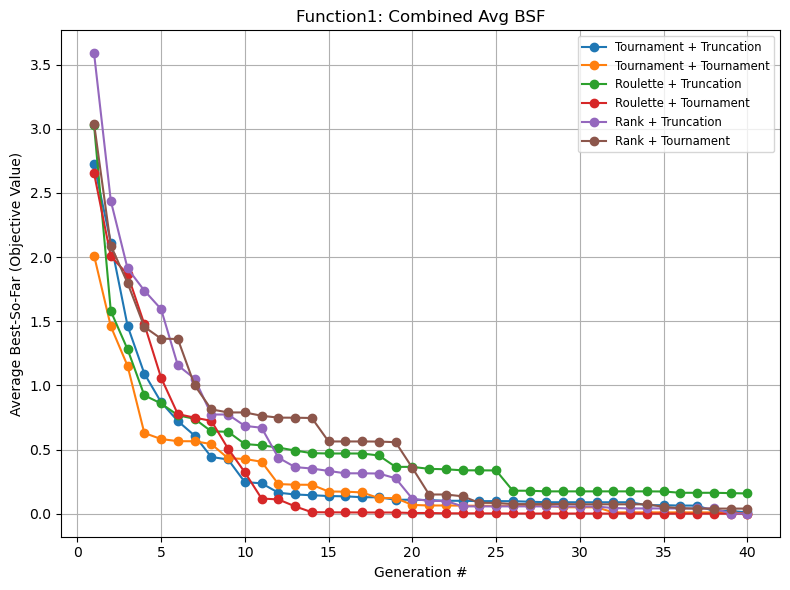

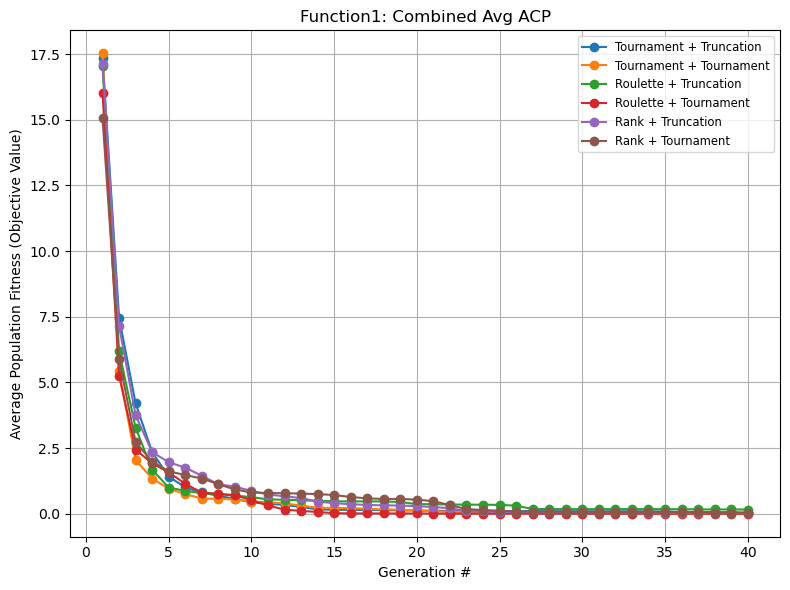


===== Running GA on Function2 =====
Running: Tournament + Truncation
Running: Tournament + Tournament
Running: Roulette + Truncation
Running: Roulette + Tournament
Running: Rank + Truncation
Running: Rank + Tournament


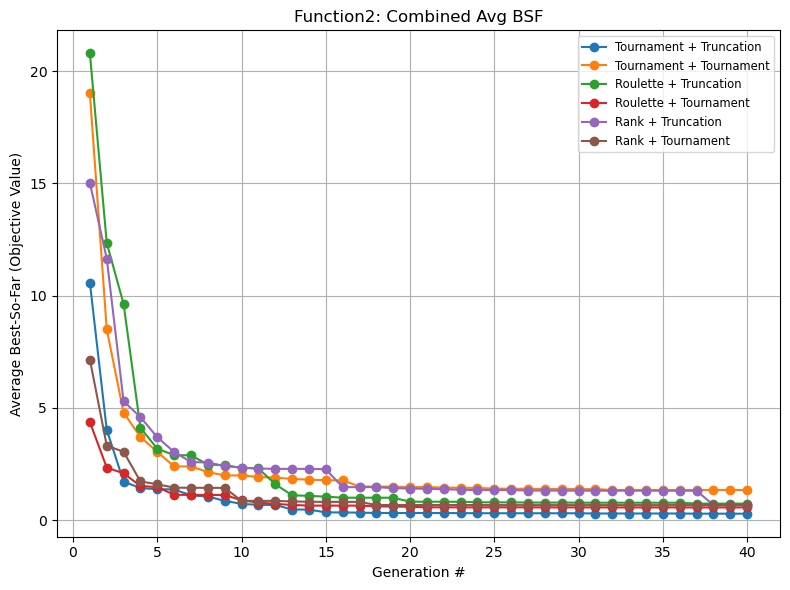

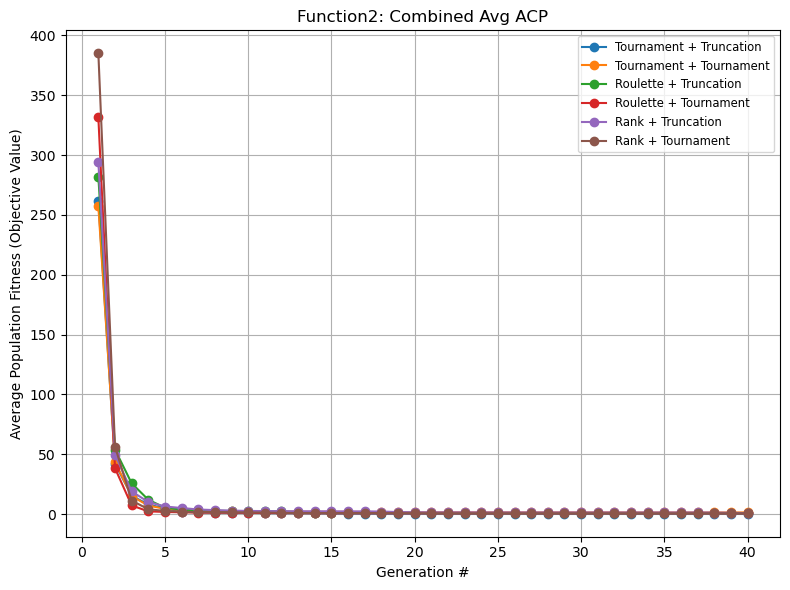

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ============================================
# Objective Functions (Minimization)
# ============================================

def func1(x, y):
    """
    Function 1: f(x, y) = x^2 + y^2
    Domain: -5 <= x, y <= 5
    """
    return x**2 + y**2

def func2(x, y):
    """
    Function 2: f(x, y) = 100 * (x^2 – y)^2 + (1 – x)^2
    Domain: -2 <= x <= 2, -1 <= y <= 3
    """
    return 100.0 * (x**2 - y)**2 + (1.0 - x)**2

# ============================================
# Binary‐Encoding Helpers
# ============================================

def decode_chromosome(chromosome, variable_ranges, bits_per_var):
    """
    Convert a binary chromosome (list of 0/1) into real‐valued variables.
    Args:
        chromosome: list of 0/1, length = bits_per_var * n_variables
        variable_ranges: list of (min_val, max_val) for each variable
        bits_per_var: int, number of bits allocated per variable
    Returns:
        variables: list of floats, one per variable
    """
    variables = []
    n_variables = len(variable_ranges)
    for i in range(n_variables):
        start = i * bits_per_var
        end = start + bits_per_var
        bit_segment = chromosome[start:end]
        decimal_value = int(''.join(str(bit) for bit in bit_segment), 2)
        min_val, max_val = variable_ranges[i]
        # scale to [min_val, max_val]
        real_val = min_val + (decimal_value / (2**bits_per_var - 1)) * (max_val - min_val)
        variables.append(real_val)
    return variables

def evaluate_fitness(chromosome, variable_ranges, bits_per_var, objective_fn):
    """
    Decode a chromosome and evaluate its objective function (to be minimized).
    Returns the objective function value.
    """
    x_vals = decode_chromosome(chromosome, variable_ranges, bits_per_var)
    return objective_fn(*x_vals)

# ============================================
# Population Initialization
# ============================================

def initialize_population(pop_size, chromosome_length):
    """
    Create an initial population of random binary chromosomes.
    Each chromosome is a list of length chromosome_length with 0/1 bits.
    """
    return [
        [random.randint(0, 1) for _ in range(chromosome_length)]
        for _ in range(pop_size)
    ]

# ============================================
# Parent Selection Methods
# ============================================

def tournament_selection(population, fitnesses, k=2):
    """
    Binary Tournament Selection: pick k random individuals, return the one with lowest fitness.
    Args:
        population: list of chromosomes
        fitnesses: list of floats (same length as population), lower is better
        k: tournament size (default 2)
    Returns:
        A single chromosome (list of 0/1)
    """
    contestants = random.sample(range(len(population)), k)
    winner_idx = min(contestants, key=lambda i: fitnesses[i])
    return population[winner_idx][:]  # return a copy

def roulette_selection(population, fitnesses):
    """
    Roulette‐Wheel Selection for minimization: invert fitness by (max_f - f + epsilon).
    Returns one chromosome.
    """
    max_f = max(fitnesses)
    adjusted = [max_f - f + 1e-10 for f in fitnesses]  # higher is better
    total = sum(adjusted)
    if total <= 0:
        return random.choice(population)[:]  # fallback
    pick = random.uniform(0, total)
    current = 0.0
    for i, a in enumerate(adjusted):
        current += a
        if current >= pick:
            return population[i][:]
    return population[-1][:]  # fallback

def rank_selection(population, fitnesses):
    """
    Rank‐Based Selection for minimization. Assign ranks so best (smallest f) has largest rank.
    Then perform roulette on ranks.
    """
    sorted_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i])  # best first
    N = len(fitnesses)
    # Create a rank list: rank[i] = N - position_in_sorted(i)
    rank_values = [0] * N
    for position, idx in enumerate(sorted_indices):
        rank_values[idx] = N - position
    total_rank = sum(rank_values)
    if total_rank <= 0:
        return random.choice(population)[:]
    pick = random.uniform(0, total_rank)
    current = 0.0
    for i, r in enumerate(rank_values):
        current += r
        if current >= pick:
            return population[i][:]
    return population[-1][:]

# ============================================
# Crossover Operators (Binary)
# ============================================

def single_point_crossover(parent1, parent2):
    """
    Single‐Point Crossover on two binary parents.
    Returns two children.
    """
    L = len(parent1)
    point = random.randint(1, L - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def two_point_crossover(parent1, parent2):
    """
    Two‐Point Crossover on two binary parents.
    """
    L = len(parent1)
    p1, p2 = sorted(random.sample(range(1, L), 2))
    child1 = parent1[:p1] + parent2[p1:p2] + parent1[p2:]
    child2 = parent2[:p1] + parent1[p1:p2] + parent2[p2:]
    return child1, child2

def uniform_crossover(parent1, parent2):
    """
    Uniform Crossover: each bit is chosen from parent1 or parent2 with 50% chance.
    """
    L = len(parent1)
    child1 = []
    child2 = []
    for i in range(L):
        if random.random() < 0.5:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])
    return child1, child2

# ============================================
# Mutation Operators (Binary)
# ============================================

def bit_flip_mutation(chromosome, mutation_rate):
    """
    Bit‐Flip Mutation: each bit flips with probability mutation_rate.
    """
    L = len(chromosome)
    mutated = chromosome[:]
    for i in range(L):
        if random.random() < mutation_rate:
            mutated[i] = 1 - mutated[i]
    return mutated

def swap_mutation(chromosome, mutation_rate):
    """
    Swap Mutation: with probability mutation_rate, pick two random positions and swap them.
    """
    mutated = chromosome[:]
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(chromosome)), 2)
        mutated[i], mutated[j] = mutated[j], mutated[i]
    return mutated

def inversion_mutation(chromosome, mutation_rate):
    """
    Inversion Mutation: with probability mutation_rate, pick two points i<j and reverse substring.
    """
    mutated = chromosome[:]
    if random.random() < mutation_rate:
        i, j = sorted(random.sample(range(len(chromosome)), 2))
        mutated[i:j+1] = reversed(mutated[i:j+1])
    return mutated

# ============================================
# Survival Selection Methods
# ============================================

def truncation_survival(parents, offspring, parent_fitnesses, offspring_fitnesses, pop_size):
    """
    Truncation: combine (parents + offspring), sort by fitness ascending, keep top pop_size.
    Args:
        parents: list of chromosomes
        offspring: list of chromosomes
        parent_fitnesses: list of floats
        offspring_fitnesses: list of floats
        pop_size: int
    Returns:
        next_population: list of chromosomes of length pop_size
        next_fitnesses: list of floats of length pop_size
    """
    combined = parents + offspring
    combined_fits = parent_fitnesses + offspring_fitnesses
    sorted_idx = sorted(range(len(combined)), key=lambda i: combined_fits[i])
    survivors_idx = sorted_idx[:pop_size]
    next_population = [combined[i][:] for i in survivors_idx]
    next_fitnesses = [combined_fits[i] for i in survivors_idx]
    return next_population, next_fitnesses

def tournament_survival(parents, offspring, parent_fitnesses, offspring_fitnesses, pop_size):
    """
    Tournament Survival (size‐2) without replacement:  
    Randomly pair up (parents + offspring) into pop_size pairs, pick the better in each pair.
    """
    combined = parents + offspring
    combined_fits = parent_fitnesses + offspring_fitnesses
    N = len(combined)
    assert N == 2 * pop_size, "Need exactly 2 * pop_size individuals for tournament survival."
    indices = list(range(N))
    random.shuffle(indices)
    next_population = []
    next_fitnesses = []
    for i in range(0, N, 2):
        idx1 = indices[i]
        idx2 = indices[i+1]
        if combined_fits[idx1] <= combined_fits[idx2]:
            next_population.append(combined[idx1][:])
            next_fitnesses.append(combined_fits[idx1])
        else:
            next_population.append(combined[idx2][:])
            next_fitnesses.append(combined_fits[idx2])
    return next_population, next_fitnesses

# ============================================
# Single GA Run (One Generation Loop)
# ============================================

def run_ga_once(
    objective_fn,
    variable_ranges,
    chromosome_length,
    pop_size,
    bits_per_var,
    parent_selection_method,
    survival_selection_method,
    crossover_method,
    mutation_method,
    mutation_rate,
    elite_size,
    generations
):
    """
    Run one GA run for a fixed number of generations, return:
      - bsf_history: list of length generations, best-so-far fitness
      - acp_history: list of length generations, average fitness of current population
    """
    # Initialize random population of binary chromosomes
    population = initialize_population(pop_size, chromosome_length)
    # Evaluate initial fitnesses (raw objective, lower is better)
    fitnesses = [
        evaluate_fitness(chrom, variable_ranges, bits_per_var, objective_fn)
        for chrom in population
    ]
    
    best_so_far = min(fitnesses)
    bsf_history = []
    acp_history = []
    
    for gen in range(generations):
        # --- Record Current Generation Statistics ---
        current_best = min(fitnesses)
        if current_best < best_so_far:
            best_so_far = current_best
        avg_fit = sum(fitnesses) / len(fitnesses)
        bsf_history.append(best_so_far)
        acp_history.append(avg_fit)
        
        # --- Elitism: keep top 'elite_size' individuals ---
        sorted_idx = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i])
        elites = [population[i][:] for i in sorted_idx[:elite_size]]
        elites_fits = [fitnesses[i] for i in sorted_idx[:elite_size]]
        
        # --- Parent Selection & Offspring Generation ---
        offspring = []
        offspring_fits = []
        while len(offspring) < pop_size:
            # Select two parents
            if parent_selection_method == 'tournament':
                p1 = tournament_selection(population, fitnesses, k=2)
                p2 = tournament_selection(population, fitnesses, k=2)
            elif parent_selection_method == 'roulette':
                p1 = roulette_selection(population, fitnesses)
                p2 = roulette_selection(population, fitnesses)
            elif parent_selection_method == 'rank':
                p1 = rank_selection(population, fitnesses)
                p2 = rank_selection(population, fitnesses)
            else:
                raise ValueError(f"Unknown parent selection method: {parent_selection_method}")
            
            # Crossover
            if crossover_method == 'single_point':
                c1, c2 = single_point_crossover(p1, p2)
            elif crossover_method == 'two_point':
                c1, c2 = two_point_crossover(p1, p2)
            elif crossover_method == 'uniform':
                c1, c2 = uniform_crossover(p1, p2)
            else:
                raise ValueError(f"Unknown crossover method: {crossover_method}")
            
            # Mutation
            if mutation_method == 'bit_flip':
                c1m = bit_flip_mutation(c1, mutation_rate)
                c2m = bit_flip_mutation(c2, mutation_rate)
            elif mutation_method == 'swap':
                c1m = swap_mutation(c1, mutation_rate)
                c2m = swap_mutation(c2, mutation_rate)
            elif mutation_method == 'inversion':
                c1m = inversion_mutation(c1, mutation_rate)
                c2m = inversion_mutation(c2, mutation_rate)
            else:
                raise ValueError(f"Unknown mutation method: {mutation_method}")
            
            # Evaluate offspring fitness
            f1 = evaluate_fitness(c1m, variable_ranges, bits_per_var, objective_fn)
            f2 = evaluate_fitness(c2m, variable_ranges, bits_per_var, objective_fn)
            
            offspring.append(c1m)
            offspring_fits.append(f1)
            if len(offspring) < pop_size:
                offspring.append(c2m)
                offspring_fits.append(f2)
        
        # --- Survival Selection: combine parents (population) + offspring ---
        if survival_selection_method == 'truncation':
            population, fitnesses = truncation_survival(
                parents=population,
                offspring=offspring,
                parent_fitnesses=fitnesses,
                offspring_fitnesses=offspring_fits,
                pop_size=pop_size
            )
        elif survival_selection_method == 'tournament':
            population, fitnesses = tournament_survival(
                parents=population,
                offspring=offspring,
                parent_fitnesses=fitnesses,
                offspring_fitnesses=offspring_fits,
                pop_size=pop_size
            )
        else:
            raise ValueError(f"Unknown survival selection method: {survival_selection_method}")
        
        # --- Ensure elites survive if using truncation survival ---
        # (In truncation_survival, the top individuals are automatically kept.
        #  If tournament survival is used without elitism, elites might be lost.
        #  To guarantee elitism under tournament survival, we can reinsert elites.)
        if survival_selection_method == 'tournament':
            # Replace worst individuals with elites (if any elite is missing)
            combined_survivors = population[:]
            combined_survivor_fits = fitnesses[:]
            # Identify the worst indices in current survivors to replace
            worst_idx_sorted = sorted(range(len(combined_survivor_fits)),
                                      key=lambda i: combined_survivor_fits[i],
                                      reverse=True)
            replace_count = 0
            for e_chrom, e_fit in zip(elites, elites_fits):
                # If elite not already in population (by fitness), replace the worst
                if e_fit < max(combined_survivor_fits):
                    idx_replace = worst_idx_sorted[replace_count]
                    combined_survivors[idx_replace] = e_chrom[:]
                    combined_survivor_fits[idx_replace] = e_fit
                    replace_count += 1
                    if replace_count >= len(elites):
                        break
            population = combined_survivors
            fitnesses = combined_survivor_fits
    
    return bsf_history, acp_history

# ============================================
# Run Multiple Independent GA Runs & Average
# ============================================

def run_experiment(
    objective_fn,
    variable_ranges,
    chromosome_length=20,
    pop_size=10,
    parent_selection_method='tournament',
    survival_selection_method='truncation',
    crossover_method='single_point',
    mutation_method='bit_flip',
    mutation_rate=0.01,
    elite_size=2,
    generations=40,
    runs=10
):
    """
    Perform 'runs' independent GA runs, collect:
      - average_bsf: mean best‐so‐far per generation (length = generations)
      - average_acp: mean average‐population‐fitness per generation
    Returns:
      avg_bsf, avg_acp (both lists of length = generations)
    """
    n_variables = len(variable_ranges)
    bits_per_var = chromosome_length // n_variables
    
    all_bsf = np.zeros((runs, generations))
    all_acp = np.zeros((runs, generations))
    
    for r in range(runs):
        bsf_hist, acp_hist = run_ga_once(
            objective_fn=objective_fn,
            variable_ranges=variable_ranges,
            chromosome_length=chromosome_length,
            pop_size=pop_size,
            bits_per_var=bits_per_var,
            parent_selection_method=parent_selection_method,
            survival_selection_method=survival_selection_method,
            crossover_method=crossover_method,
            mutation_method=mutation_method,
            mutation_rate=mutation_rate,
            elite_size=elite_size,
            generations=generations
        )
        all_bsf[r, :] = bsf_hist
        all_acp[r, :] = acp_hist
    
    avg_bsf = np.mean(all_bsf, axis=0)
    avg_acp = np.mean(all_acp, axis=0)
    return avg_bsf.tolist(), avg_acp.tolist()

# ============================================
# Plotting Utility (Combined Curves)
# ============================================

def plot_combined(metric_dict, ylabel, title):
    """
    Plot multiple curves on the same figure.
    metric_dict: dict mapping 'label' -> list of values (length = generations)
    """
    generations = len(next(iter(metric_dict.values())))
    x = np.arange(1, generations + 1)
    plt.figure(figsize=(8, 6))
    for label, values in metric_dict.items():
        plt.plot(x, values, marker='o', label=label)
    plt.xlabel('Generation #')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()

# ============================================
# Main: Run All Combinations & Plot
# ============================================

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    
    # Problem definitions
    problems = {
        'Function1': {
            'fn': func1,
            'ranges': [(-5.0, 5.0), (-5.0, 5.0)]
        },
        'Function2': {
            'fn': func2,
            'ranges': [(-2.0, 2.0), (-1.0, 3.0)]
        }
    }
    
    # Parent‐selection options
    parent_methods = {
        'Tournament': 'tournament',
        'Roulette':  'roulette',
        'Rank':      'rank'
    }
    # Survival‐selection options
    survival_methods = {
        'Truncation': 'truncation',
        'Tournament': 'tournament'
    }
    
    # GA hyperparameters (as per assignment)
    chromosome_length = 20   # total bits per chromosome
    pop_size = 10            # population size
    generations = 40         # generations per run
    runs = 10                # independent runs to average over
    mutation_rate = 0.01     # per-bit mutation rate
    elite_size = 2           # number of elites to carry over
    crossover_method = 'single_point'
    mutation_method = 'bit_flip'
    
    # For each problem, run all combinations
    for prob_name, prob_data in problems.items():
        objective_fn = prob_data['fn']
        variable_ranges = prob_data['ranges']
        
        print(f"\n===== Running GA on {prob_name} =====")
        
        # Dictionaries to store average BSF and ACP for each combination
        combined_bsf = {}
        combined_acp = {}
        
        for p_label, p_method in parent_methods.items():
            for s_label, s_method in survival_methods.items():
                combo_label = f"{p_label} + {s_label}"
                print(f"Running: {combo_label}")
                
                avg_bsf, avg_acp = run_experiment(
                    objective_fn=objective_fn,
                    variable_ranges=variable_ranges,
                    chromosome_length=chromosome_length,
                    pop_size=pop_size,
                    parent_selection_method=p_method,
                    survival_selection_method=s_method,
                    crossover_method=crossover_method,
                    mutation_method=mutation_method,
                    mutation_rate=mutation_rate,
                    elite_size=elite_size,
                    generations=generations,
                    runs=runs
                )
                
                combined_bsf[combo_label] = avg_bsf
                combined_acp[combo_label] = avg_acp
        
        # Plot combined Best‐So‐Far curves
        plot_combined(
            combined_bsf,
            ylabel='Average Best‐So‐Far (Objective Value)',
            title=f"{prob_name}: Combined Avg BSF"
        )
        # Plot combined Average‐Current‐Population curves
        plot_combined(
            combined_acp,
            ylabel='Average Population Fitness (Objective Value)',
            title=f"{prob_name}: Combined Avg ACP"
        )
